# Process All Formation Data
Get all of the data together. Summarize the results and plot correlations.

In [1]:
import numpy as np
import pandas as pd
import glob
import pprint
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import re
from src.formation import FormationCell

## Configure plot settings

In [2]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Helvetica'],
                  'size': 18
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (10, 8)
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes', labelsize='medium', grid=True)
plt.rc('legend', fontsize='medium')

DPI = 150
VOLTAGE_LIMITS = (2.95, 4.25)
CAPACITY_LIMITS = (0, 3)

## Load resources

In [3]:
formation_cells = []
cellid_list = np.arange(1, 41)

for cellid in cellid_list:
    formation_cells.append(FormationCell(cellid))
    
for cell in formation_cells:
    print(cell)

Formation Cell 1
Formation Cell 2
Formation Cell 3
Formation Cell 4
Formation Cell 5
Formation Cell 6
Formation Cell 7
Formation Cell 8
Formation Cell 9
Formation Cell 10
Formation Cell 11
Formation Cell 12
Formation Cell 13
Formation Cell 14
Formation Cell 15
Formation Cell 16
Formation Cell 17
Formation Cell 18
Formation Cell 19
Formation Cell 20
Formation Cell 21
Formation Cell 22
Formation Cell 23
Formation Cell 24
Formation Cell 25
Formation Cell 26
Formation Cell 27
Formation Cell 28
Formation Cell 29
Formation Cell 30
Formation Cell 31
Formation Cell 32
Formation Cell 33
Formation Cell 34
Formation Cell 35
Formation Cell 36
Formation Cell 37
Formation Cell 38
Formation Cell 39
Formation Cell 40


## Plot cycles to x% Retention

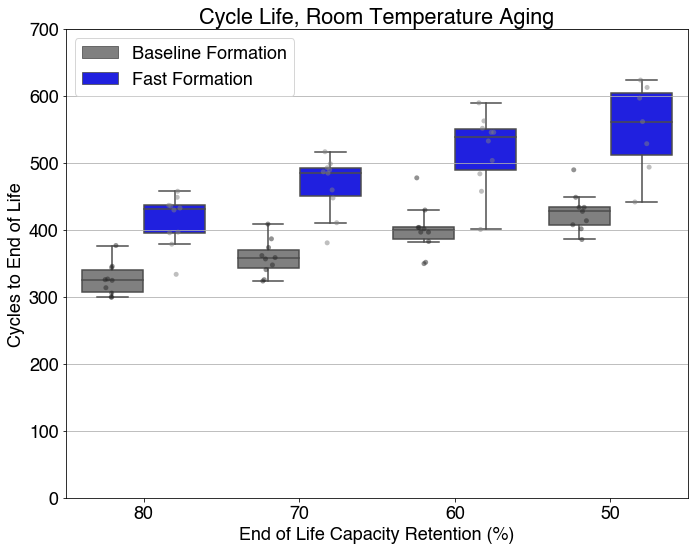

In [4]:
# Get the data
results_list = []

for cell in formation_cells:
    
    if cell.is_room_temp():

        stats_dict = cell.get_aging_test_summary_statistics()

        for retention in np.array([50, 60, 70, 80]):

            curr_dict = dict()
            curr_dict['cellid'] = cell.cellid
            curr_dict['formation_type'] = 'Baseline Formation' if cell.is_baseline_formation() else 'Fast Formation'
            curr_dict['retention'] = retention
            curr_dict['cycles'] = stats_dict[f'cycles_to_{retention}_pct']

            results_list.append(curr_dict)
        
df = pd.DataFrame(results_list)


# Make the box plot
bp = sns.boxplot(y='cycles', x='retention',
                 data=df,
                 palette=['grey', 'b'],
                 hue='formation_type',
                 order=[80, 70, 60, 50],
                 showfliers=False
                )

bp = sns.stripplot(y='cycles', x='retention', 
                   data=df, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   alpha=0.5,
                   order=[80, 70, 60, 50],
                   hue='formation_type',
                   color='grey')

bp.set(xlabel='End of Life Capacity Retention (%)',
       ylabel='Cycles to End of Life',
       ylim=(0, 700),
       title='Cycle Life, Room Temperature Aging')


handles, labels = bp.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])

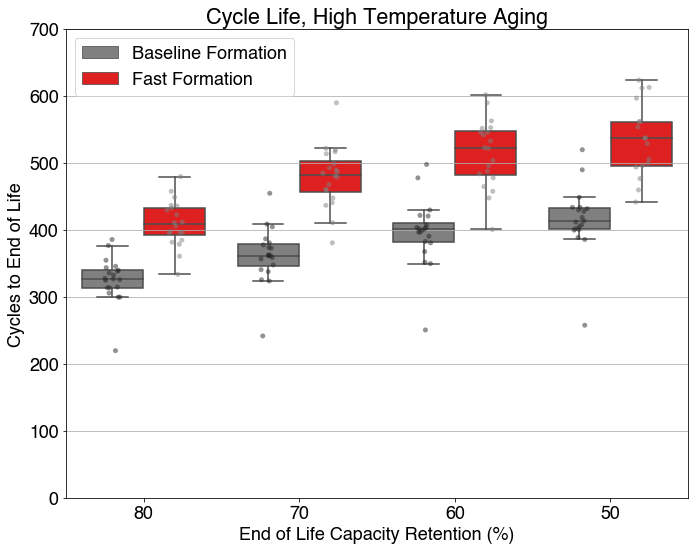

In [5]:
# Get the data
results_list = []

for cell in formation_cells:
    
    if ~cell.is_room_temp():

        stats_dict = cell.get_aging_test_summary_statistics()

        for retention in np.array([50, 60, 70, 80]):

            curr_dict = dict()
            curr_dict['cellid'] = cell.cellid
            curr_dict['formation_type'] = 'Baseline Formation' if cell.is_baseline_formation() else 'Fast Formation'
            curr_dict['retention'] = retention
            curr_dict['cycles'] = stats_dict[f'cycles_to_{retention}_pct']

            results_list.append(curr_dict)
        
df = pd.DataFrame(results_list)


# Make the box plot
bp = sns.boxplot(y='cycles', x='retention',
                 data=df,
                 palette=['grey', 'r'],
                 order=[80, 70, 60, 50],
                 hue='formation_type',
                 showfliers=False
                )

bp = sns.stripplot(y='cycles', x='retention', 
                   data=df, 
                   jitter=True,
                   dodge=True, 
                   marker='o', 
                   order=[80, 70, 60, 50],
                   alpha=0.5,
                   hue='formation_type',
                   color='grey')

bp.set(xlabel='End of Life Capacity Retention (%)',
       ylabel='Cycles to End of Life',
       ylim=(0, 700),
       title='Cycle Life, High Temperature Aging')


handles, labels = bp.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])

## Compare the DC resistances

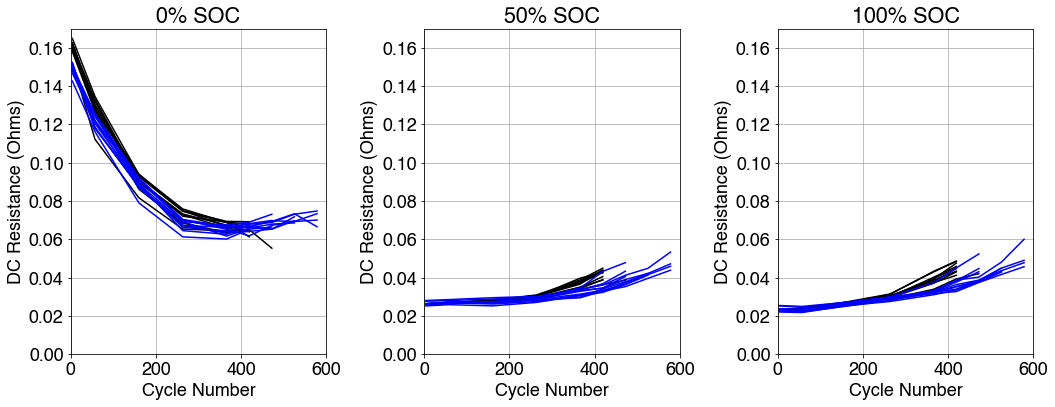

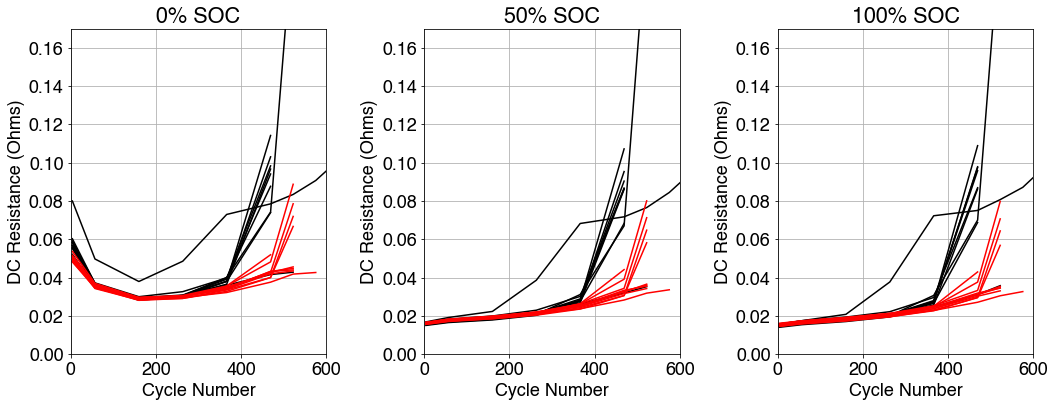

In [6]:
# Room temperature

fig, axs = plt.subplots(1, 3, figsize=(15,6))

for cell in formation_cells:
    
    if cell.is_room_temp():
        df = cell.summarize_hppc_pulse_statistics()
        color = 'k' if cell.is_baseline_formation() else 'b'
        axs[0].plot(df['cycle_index'], df['dcr_soc_0'], color=color)   
        axs[1].plot(df['cycle_index'], df['dcr_soc_50'], color=color)
        axs[2].plot(df['cycle_index'], df['dcr_soc_100'], color=color)
            
for ax in axs:
    ax.set(xlabel='Cycle Number', 
           ylabel='DC Resistance (Ohms)', 
           xlim=(0, 600),
           ylim=(0.000, 0.17)
          )
    
axs[0].set(title='0% SOC')
axs[1].set(title='50% SOC')
axs[2].set(title='100% SOC')

plt.show()


# High temperatures
fig, axs = plt.subplots(1, 3, figsize=(15,6))

for cell in formation_cells:
    
    if not cell.is_room_temp():
        df = cell.summarize_hppc_pulse_statistics()
        color = 'k' if cell.is_baseline_formation() else 'r'
        axs[0].plot(df['cycle_index'], df['dcr_soc_0'], color=color)   
        axs[1].plot(df['cycle_index'], df['dcr_soc_50'], color=color)
        axs[2].plot(df['cycle_index'], df['dcr_soc_100'], color=color)
            
for ax in axs:
    ax.set(xlabel='Cycle Number', 
           ylabel='DC Resistance (Ohms)', 
           xlim=(0, 600),
           ylim=(0.000, 0.17)
          )
    
axs[0].set(title='0% SOC')
axs[1].set(title='50% SOC')
axs[2].set(title='100% SOC')

plt.show()



## Get the summary statistics for each cell

In [7]:
all_summary_data = []

for cell in formation_cells:
    
    curr_summary = dict()
    
    curr_summary.update(cell.get_formation_test_summary_statistics())
    curr_summary.update(cell.get_aging_test_summary_statistics())
    curr_summary['is_room_temp_aging'] = cell.is_room_temp()
    curr_summary['is_baseline_formation'] = cell.is_baseline_formation()
    curr_summary['is_plating'] = cell.is_plating()
    curr_summary['swelling_severity'] = cell.get_swelling_severity()
    curr_summary['electrolyte_weight_g'] = cell.get_electrolyte_weight()
    curr_summary['cellid'] = cell.cellid
    all_summary_data.append(curr_summary)
    
    pprint.pprint(curr_summary)

{'cellid': 1,
 'cycles_to_50_pct': 400,
 'cycles_to_60_pct': 391,
 'cycles_to_70_pct': 373,
 'cycles_to_80_pct': 328,
 'dcr_0_soc_at_c400': 0.05950327732194693,
 'dcr_100_soc_at_c400': 0.05056758094123025,
 'dcr_50_soc_at_c400': 0.05008484234743672,
 'electrolyte_weight_g': 11.060000000000002,
 'form_final_capacity': 2.3672251134,
 'form_first_charge_capacity_ah': 2.7553016043,
 'form_first_cycle_efficiency': 0.8393758383440433,
 'form_first_discharge_capacity_ah': 2.312733594,
 'initial_capacity': 2.39221863018,
 'initial_capacity_std': 0.06560055570265248,
 'initial_cell_dcr_0_soc': 0.05665079036290325,
 'initial_cell_dcr_100_soc': 0.014003346819063447,
 'initial_cell_dcr_50_soc': 0.01496414788148397,
 'is_baseline_formation': True,
 'is_plating': False,
 'is_room_temp_aging': False,
 'retention_at_c400': 0.49205068263824653,
 'swelling_severity': 0}
{'cellid': 2,
 'cycles_to_50_pct': 401,
 'cycles_to_60_pct': 368,
 'cycles_to_70_pct': 338,
 'cycles_to_80_pct': 314,
 'dcr_0_soc_at_c4

{'cellid': 11,
 'cycles_to_50_pct': nan,
 'cycles_to_60_pct': 430,
 'cycles_to_70_pct': 387,
 'cycles_to_80_pct': 346,
 'dcr_0_soc_at_c400': 0.06391588229875521,
 'dcr_100_soc_at_c400': 0.039789390246500744,
 'dcr_50_soc_at_c400': 0.03734989983313411,
 'electrolyte_weight_g': 11.050000000000004,
 'form_final_capacity': 2.389859425,
 'form_first_charge_capacity_ah': 2.6987951434,
 'form_first_cycle_efficiency': 0.8661745235894439,
 'form_first_discharge_capacity_ah': 2.3376275976,
 'initial_capacity': 2.2536418436399996,
 'initial_capacity_std': 0.06621623287279844,
 'initial_cell_dcr_0_soc': 0.16063716840730652,
 'initial_cell_dcr_100_soc': 0.023080028020888144,
 'initial_cell_dcr_50_soc': 0.02620353734766202,
 'is_baseline_formation': True,
 'is_plating': True,
 'is_room_temp_aging': True,
 'retention_at_c400': 0.6445577214051945,
 'swelling_severity': 0}
{'cellid': 12,
 'cycles_to_50_pct': 449,
 'cycles_to_60_pct': 402,
 'cycles_to_70_pct': 362,
 'cycles_to_80_pct': 325,
 'dcr_0_soc_

{'cellid': 21,
 'cycles_to_50_pct': nan,
 'cycles_to_60_pct': 484,
 'cycles_to_70_pct': 448,
 'cycles_to_80_pct': 397,
 'dcr_0_soc_at_c400': 0.06340262173722686,
 'dcr_100_soc_at_c400': 0.03586916325225771,
 'dcr_50_soc_at_c400': 0.03390980662948125,
 'electrolyte_weight_g': 11.049999999999997,
 'form_final_capacity': 2.3668098408000002,
 'form_first_charge_capacity_ah': 2.7479503772000005,
 'form_first_cycle_efficiency': 0.17607851106577108,
 'form_first_discharge_capacity_ah': 0.48385501090000005,
 'initial_capacity': 2.2595953278,
 'initial_capacity_std': 0.06649681219785106,
 'initial_cell_dcr_0_soc': 0.14258710773423958,
 'initial_cell_dcr_100_soc': 0.02327426001883183,
 'initial_cell_dcr_50_soc': 0.025957647913697087,
 'is_baseline_formation': False,
 'is_plating': True,
 'is_room_temp_aging': True,
 'retention_at_c400': 0.7953533142811802,
 'swelling_severity': 0}
{'cellid': 22,
 'cycles_to_50_pct': 442,
 'cycles_to_60_pct': 401,
 'cycles_to_70_pct': 381,
 'cycles_to_80_pct': 33

 'is_baseline_formation': False,
 'is_plating': False,
 'is_room_temp_aging': False,
 'retention_at_c400': 0.7621796330307264,
 'swelling_severity': 3}
{'cellid': 32,
 'cycles_to_50_pct': 506,
 'cycles_to_60_pct': 496,
 'cycles_to_70_pct': 479,
 'cycles_to_80_pct': 396,
 'dcr_0_soc_at_c400': 0.03565415804961628,
 'dcr_100_soc_at_c400': 0.02512042144359255,
 'dcr_50_soc_at_c400': 0.02635015349445921,
 'electrolyte_weight_g': 11.059999999999995,
 'form_final_capacity': 2.3676934466999997,
 'form_first_charge_capacity_ah': 2.7024496833,
 'form_first_cycle_efficiency': 0.1785619674556699,
 'form_first_discharge_capacity_ah': 0.4825547324,
 'initial_capacity': 2.3812795648,
 'initial_capacity_std': 0.06582573986758755,
 'initial_cell_dcr_0_soc': 0.050113080879020916,
 'initial_cell_dcr_100_soc': 0.014453098097627579,
 'initial_cell_dcr_50_soc': 0.01553577391227987,
 'is_baseline_formation': False,
 'is_plating': False,
 'is_room_temp_aging': False,
 'retention_at_c400': 0.7935530373388606,


In [8]:
df_corr = pd.DataFrame(all_summary_data)

In [9]:
df_corr

,form_first_charge_capacity_ah,form_first_discharge_capacity_ah,form_first_cycle_efficiency,form_final_capacity,initial_capacity,initial_capacity_std,cycles_to_50_pct,cycles_to_60_pct,cycles_to_70_pct,cycles_to_80_pct,...,retention_at_c400,dcr_0_soc_at_c400,dcr_50_soc_at_c400,dcr_100_soc_at_c400,is_room_temp_aging,is_baseline_formation,is_plating,swelling_severity,electrolyte_weight_g,cellid
0,2.755302,2.312734,0.839376,2.367225,2.392219,0.065601,400.0,391,373,328,...,0.492051,0.059503,0.050085,0.050568,False,True,False,0,11.06,1
1,2.698299,2.313851,0.857522,2.363418,2.390043,0.065636,401.0,368,338,314,...,0.500357,0.051329,0.042948,0.043631,False,True,False,0,11.00,2
2,2.713403,2.309945,0.851309,2.362668,2.388198,0.065309,520.0,498,455,386,...,0.782171,0.037796,0.028069,0.026762,False,True,False,1,11.01,3
3,2.696613,2.310417,0.856785,2.356018,2.372319,0.066106,389.0,381,363,315,...,0.371080,0.055565,0.048738,0.048486,False,True,False,0,11.03,4
4,2.713639,2.330587,0.858842,2.381257,2.396523,0.065685,405.0,400,381,333,...,0.595839,0.063102,0.054058,0.054076,False,True,False,0,11.02,5
5,2.711829,2.307558,0.850923,2.355594,2.375177,0.062464,430.0,422,405,355,...,0.715027,0.056354,0.046336,0.045631,False,True,False,1,10.98,6
6,2.755931,2.319138,0.841508,2.371946,2.391926,0.065629,419.0,408,362,336,...,0.631192,0.057250,0.047520,0.050590,False,True,False,0,11.05,7
7,2.707419,2.340709,0.864554,2.382960,2.396469,0.065676,412.0,402,362,340,...,0.609101,0.058974,0.049128,0.050336,False,True,False,0,11.15,8
8,2.478295,2.131502,0.860068,2.178040,2.212180,0.060095,258.0,251,242,220,...,0.073698,0.074773,0.069374,0.073176,False,True,False,3,11.06,9
9,2.688354,2.337044,0.869321,2.384860,2.381898,0.065858,432.0,421,378,339,...,0.676322,0.049862,0.040966,0.040446,False,True,False,1,11.13,10


## Make some correlation plots

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


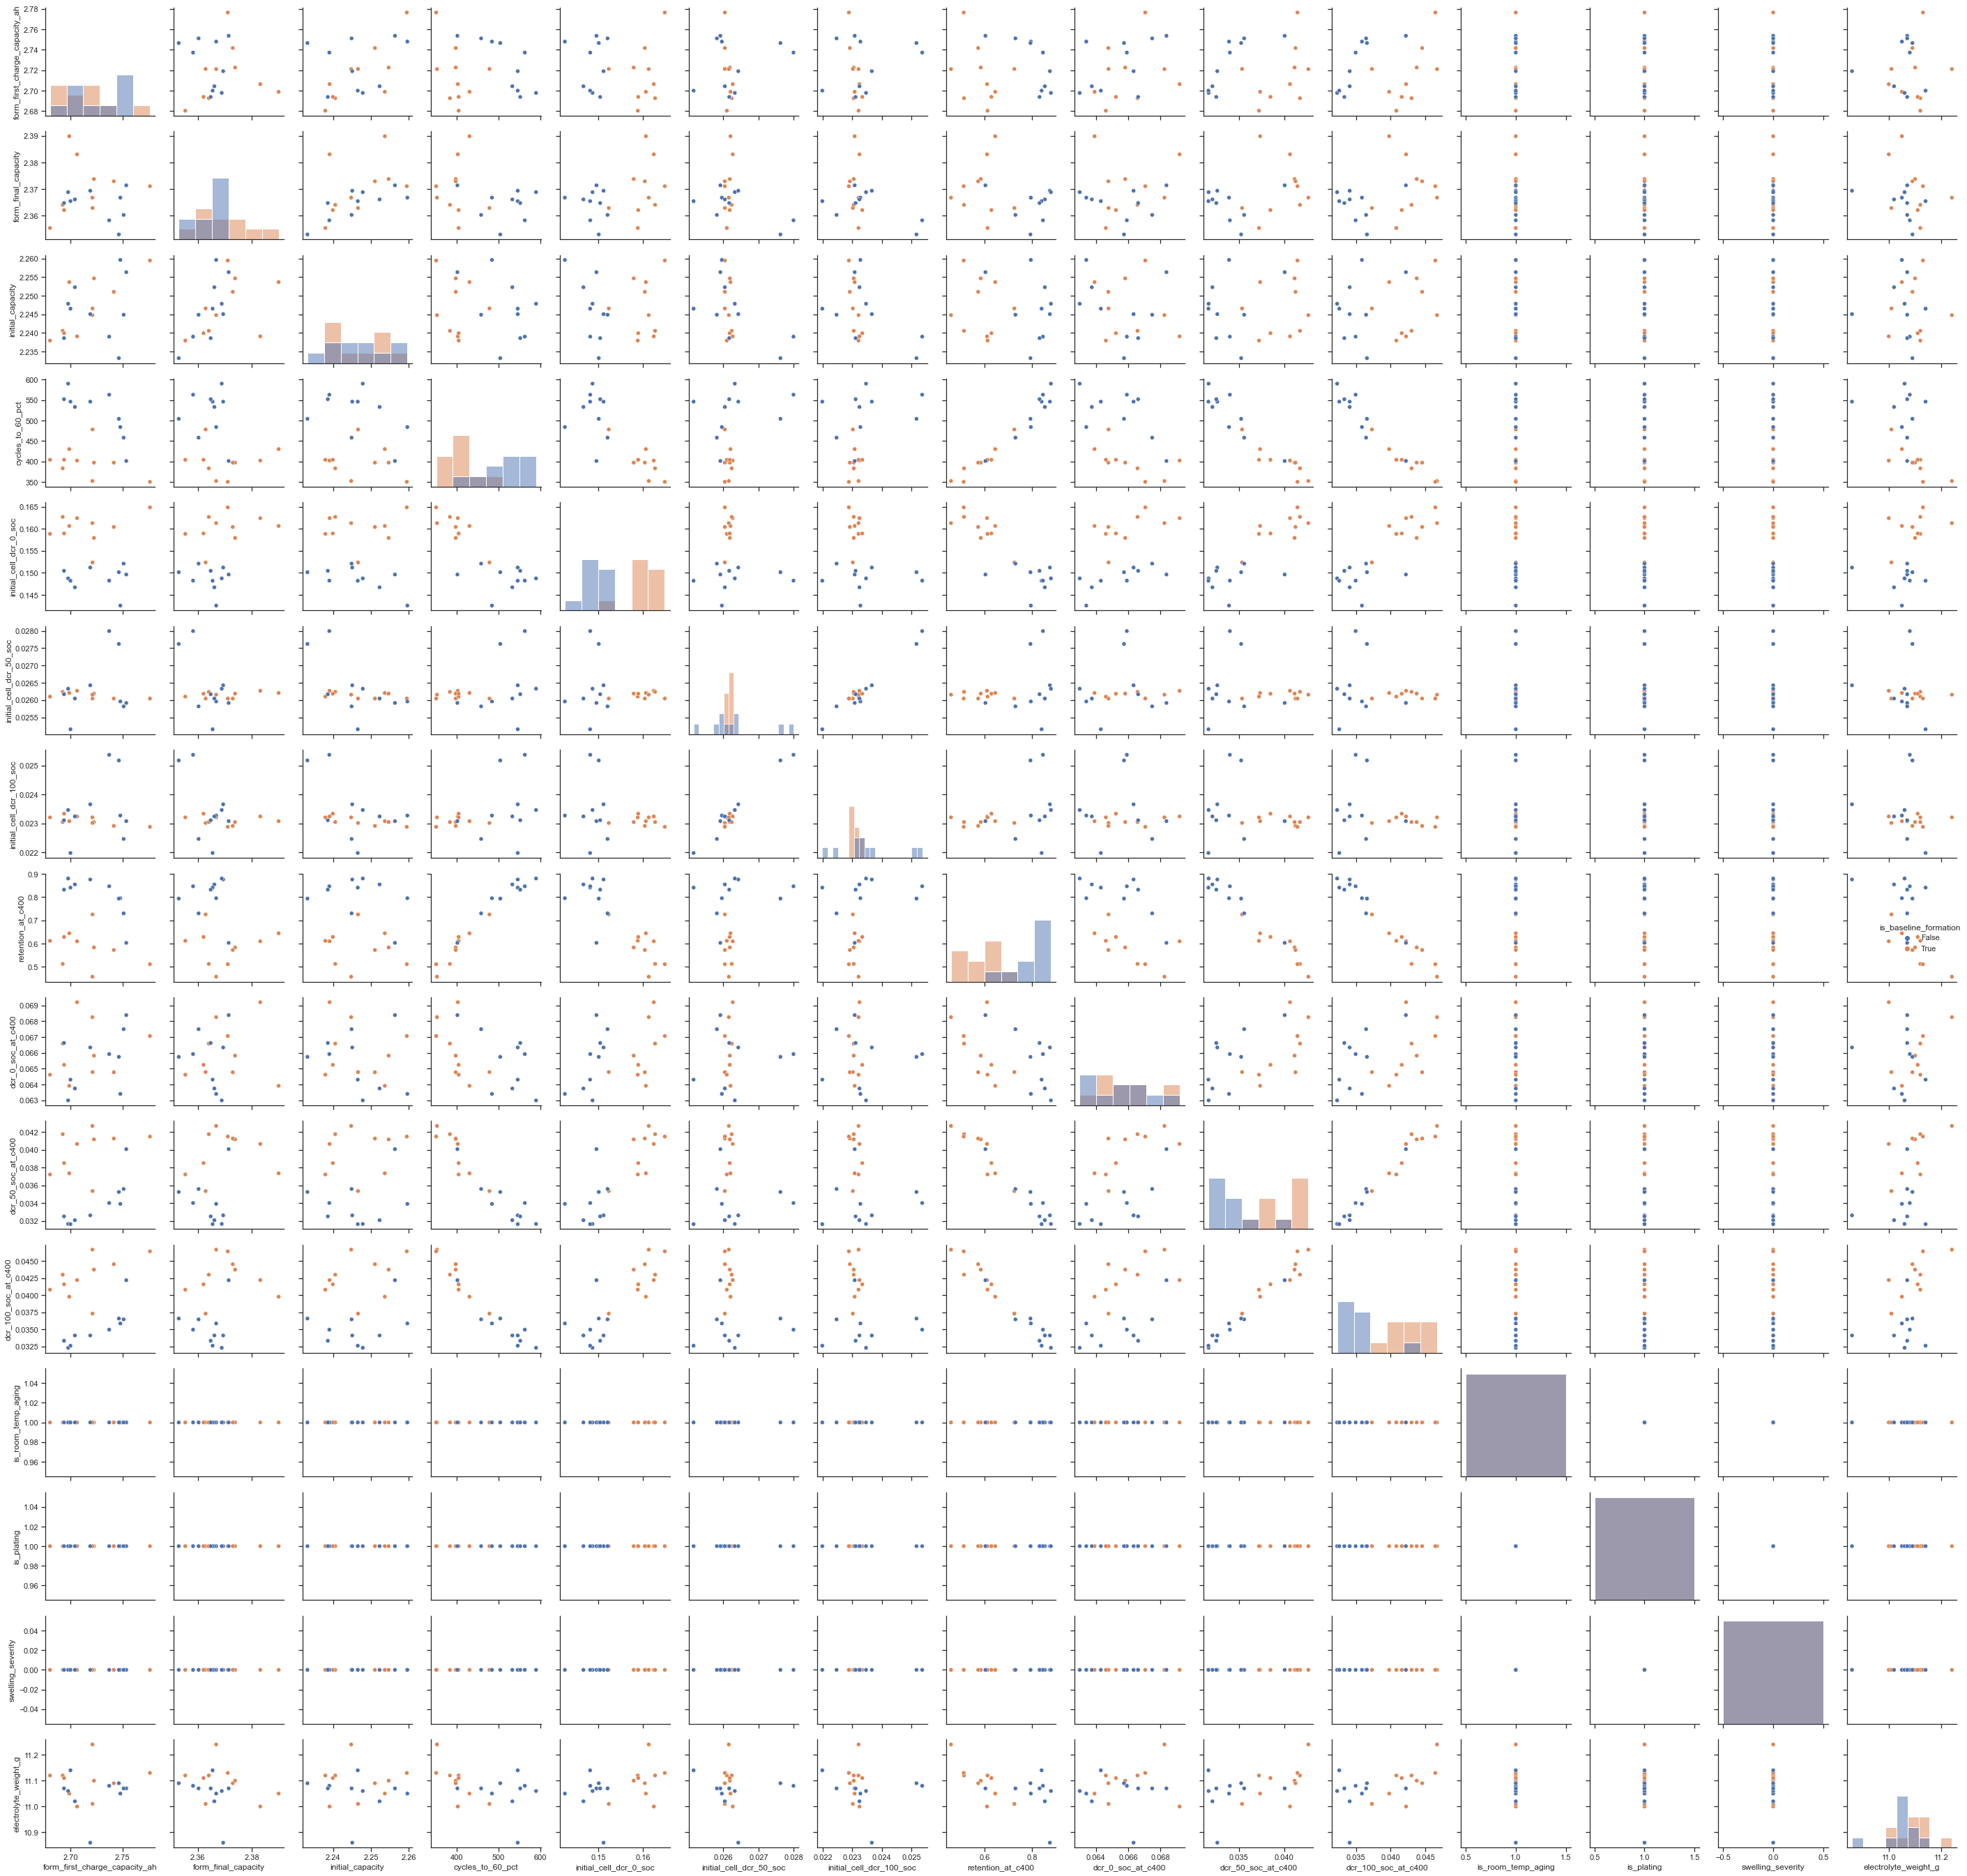

In [10]:
sns.set_theme(style="ticks")

df_plot = df_corr.drop(columns=['initial_capacity_std', 
                                'cycles_to_50_pct', 
                                'cycles_to_70_pct', 
                                'cycles_to_80_pct',
                                'form_first_discharge_capacity_ah',
                                'form_first_cycle_efficiency',
                                'cellid'])

df_plot['swelling_severity'] = df_plot['swelling_severity'].astype(float)

sns_plot = sns.pairplot(df_plot[df_plot['is_room_temp_aging'] == True], 
                        hue='is_baseline_formation',
                        diag_kind='hist')

In [11]:
sns_plot.savefig("output_room_temp.png")

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


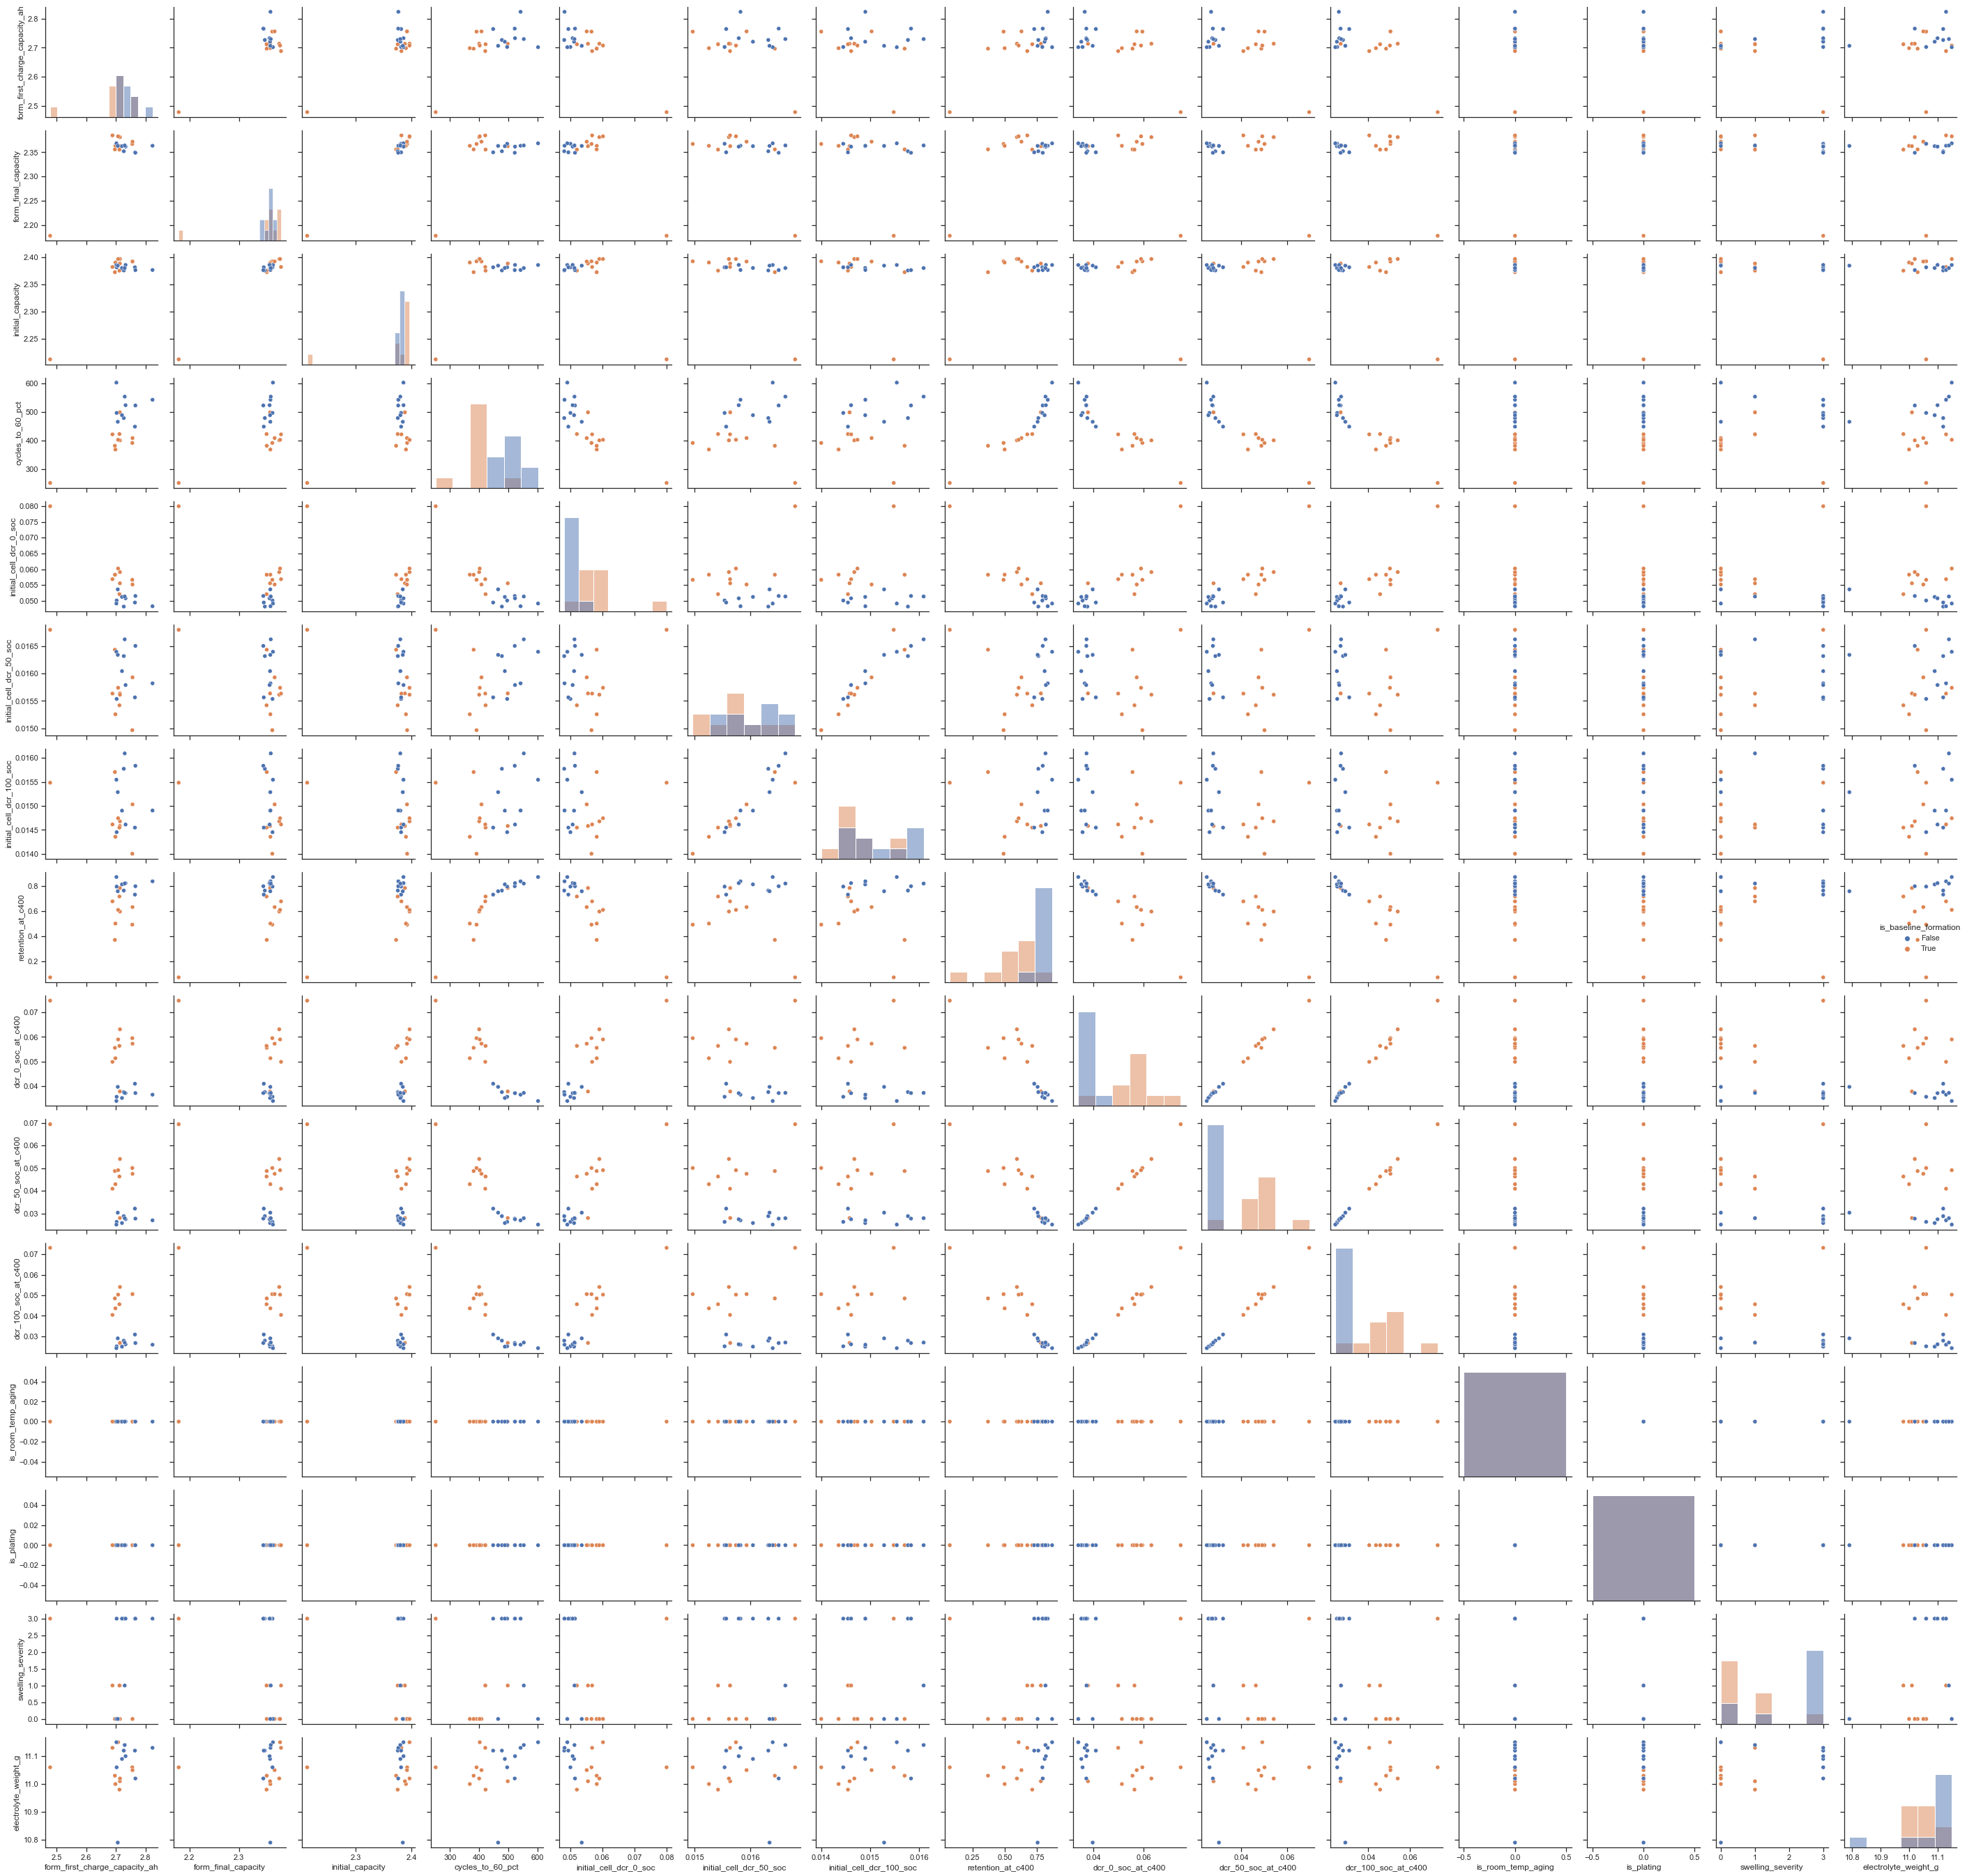

In [12]:
sns_plot = sns.pairplot(df_plot[df_plot['is_room_temp_aging'] == False], 
                        hue='is_baseline_formation',
                        diag_kind='hist')

In [13]:
sns_plot.savefig("output_hot.png")

In [16]:
df_corr.to_csv('correlation_data.csv')

## Summary of cycles to x% Retention

In [14]:
df_corr = df_corr[df_corr.cellid != 9]

df_corr.groupby(['is_baseline_formation', 'is_room_temp_aging']).agg({'cycles_to_60_pct' : ['mean', 'median', 'std']})

cycles_to_60_pct                  
                                                     mean median        std
is_baseline_formation is_room_temp_aging                                   
False                 False                    511.700000  509.0  46.180924
                      True                     517.700000  539.5  56.566676
True                  False                    410.111111  402.0  37.321055
                      True                     399.700000  399.5  36.712244